In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time
import seaborn as sns
from scipy import stats
import folium
import nltk
import string
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from folium.plugins import HeatMap
from math import radians, cos, sin, asin, sqrt

In [2]:
tic = time.time()

warnings.filterwarnings("ignore")
sns.set_context('notebook')
sns.set_style('ticks')
crayon = ['#4E79A7', '#F28E2C', '#E15759', '#76B7B2', '#59A14F',
          '#EDC949', '#AF7AA1', '#FF9DA7', '#9C755F', '#BAB0AB']
sns.set_palette("pastel")
plt.rcParams['figure.figsize'] = (16, 9)
%matplotlib inline

In [3]:
df = pd.read_csv("train.csv")

In [4]:
df.columns

Index(['name', 'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'notes', 'transit', 'access', 'interaction',
       'house_rules', 'host_id', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_identity_verified', 'street', 'neighbourhood',
       'neighbourhood_cleansed', 'city', 'zipcode', 'smart_location',
       'latitude', 'longitude', 'is_location_exact', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'square_feet', 'weekly_discount',
       'monthly_discount', 'security_deposit_perc', 'cleaning_fee_perc',
       'guests_included', 'extra_people_perc', 'minimum_nights',
       'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_

## Data Preprocessing

### Uesless columns

In [5]:
useless_cols = ["host_id","zipcode","last_review","first_review"]
df.drop(columns=useless_cols, inplace=True)

### Missing Values

In [6]:
df.isnull().sum()[:40]

name                            0
summary                         0
space                        2654
description                     0
experiences_offered             0
neighborhood_overview        3438
notes                        5538
transit                      3369
access                       3892
interaction                  3878
house_rules                  3987
host_since                      0
host_location                   8
host_about                   4363
host_response_time           4566
host_response_rate           4566
host_acceptance_rate         9838
host_is_superhost               0
host_neighbourhood           2915
host_listings_count             0
host_total_listings_count       0
host_verifications              0
host_identity_verified          0
street                          0
neighbourhood                1151
neighbourhood_cleansed          0
city                            6
smart_location                  0
latitude                        0
longitude     

In [7]:
df.isnull().sum()[40:]

weekly_discount                                 8940
monthly_discount                                9299
security_deposit_perc                           3303
cleaning_fee_perc                               2445
guests_included                                    0
extra_people_perc                                  0
minimum_nights                                     0
maximum_nights                                     0
minimum_minimum_nights                             0
maximum_minimum_nights                             0
minimum_maximum_nights                             0
maximum_maximum_nights                             0
minimum_nights_avg_ntm                             0
maximum_nights_avg_ntm                             0
availability_30                                    0
availability_60                                    0
availability_90                                    0
availability_365                                   0
number_of_reviews                             

#### Columns contains > 50% missing values

In [8]:
missing_values_cols = [df.columns[index]  for index in np.where(df.isnull().sum()>(len(df) * 0.5))[0]]
missing_values_cols

['notes',
 'host_acceptance_rate',
 'square_feet',
 'weekly_discount',
 'monthly_discount']

#### Columns contains (25%,50%) missing values

In [9]:
temp = [df.columns[index]  for index in np.where(df.isnull().sum()>(len(df) * 0.1))[0]]
missing_values_warning_cols = [x for x in temp if x not in missing_values_cols]
missing_values_warning_cols

['space',
 'neighborhood_overview',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_neighbourhood',
 'neighbourhood',
 'security_deposit_perc',
 'cleaning_fee_perc',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month']

#### "host_response_rate" preprocessing

In [10]:
df.host_response_rate = df.host_response_rate.str.replace("%","").astype(float)/100

#### Missing value columns Classification 

In [11]:
number_missing_avg_cols = ["host_response_rate","bathrooms","bedrooms","beds",'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
                          ]

number_missing_zero_cols = ["security_deposit_perc","cleaning_fee_perc","reviews_per_month"]

string_missing_cols = ["host_response_time","host_location","host_neighbourhood","neighbourhood","city","cancellation_policy"
                  ]

text_missing_cols = ["space","neighborhood_overview","transit","access","interaction","house_rules",
                     "host_about",
                    ]

#### Missing Value precessing

In [12]:
df.drop(missing_values_cols, inplace=True, axis=1)

for col in text_missing_cols:
    df[col].fillna("", inplace=True)
for col in string_missing_cols:
    df[col].fillna("None", inplace=True)
for col in number_missing_avg_cols:
    mean_val = df[col].mean()
    df[col].fillna(mean_val, inplace=True)
for col in number_missing_zero_cols:
    df[col].fillna(0, inplace=True)

#### validation

In [13]:
df.isnull().sum()[:40]

name                         0
summary                      0
space                        0
description                  0
experiences_offered          0
neighborhood_overview        0
transit                      0
access                       0
interaction                  0
house_rules                  0
host_since                   0
host_location                0
host_about                   0
host_response_time           0
host_response_rate           0
host_is_superhost            0
host_neighbourhood           0
host_listings_count          0
host_total_listings_count    0
host_verifications           0
host_identity_verified       0
street                       0
neighbourhood                0
neighbourhood_cleansed       0
city                         0
smart_location               0
latitude                     0
longitude                    0
is_location_exact            0
property_type                0
room_type                    0
accommodates                 0
bathroom

In [14]:
df.isnull().sum()[40:]

extra_people_perc                               0
minimum_nights                                  0
maximum_nights                                  0
minimum_minimum_nights                          0
maximum_minimum_nights                          0
minimum_maximum_nights                          0
maximum_maximum_nights                          0
minimum_nights_avg_ntm                          0
maximum_nights_avg_ntm                          0
availability_30                                 0
availability_60                                 0
availability_90                                 0
availability_365                                0
number_of_reviews                               0
number_of_reviews_ltm                           0
review_scores_rating                            0
review_scores_accuracy                          0
review_scores_cleanliness                       0
review_scores_checkin                           0
review_scores_communication                     0


**Review_scored will be engineered later.**

### Outlier

In [15]:
def subplot_box(df):
    """

    """

    plt.figure(figsize=(30, 90))
    num_subplot = len(df.columns)
    for i, col in enumerate(df.columns):
        plt.subplot(num_subplot//2 + 1, 2, i+1)
        sns.set_palette("pastel")
        sns.boxplot(x=df[col])
        
def plot_distributed(series):
    
    sns.distplot(series, fit=stats.norm, bins=10, color='cornflowerblue')
    (mu, sigma) = stats.norm.fit(series)
    plt.legend(['Normal dist.($\mu=$ {:.2f} and $\sigma=${:.2f})'.format(
        mu, sigma)], loc='best')
    plt.ylabel('Frequency')
    plt.title('Distribution of '+series.name)
    
def plot_outlier(series):
    plt.figure()
    plt.title(series.name)
    sns.boxplot(x=series)
    plt.figure()
    plt.hist(series)
    plt.figure()
    plot_distributed(series)
    
    
    
    
def zscore_drop_outlier(df, col_list, THRESHOLD=3):
    """
    
    """
    for col in col_list:
        z = np.abs(stats.zscore(df[col]))
        df = df[(z < THRESHOLD)]

    df.index = range(len(df))
    return df

#### Price preprocessing

In [16]:
df.price=df.price.str.replace('$','')
df.price=df.price.str.replace(',','').astype(float)

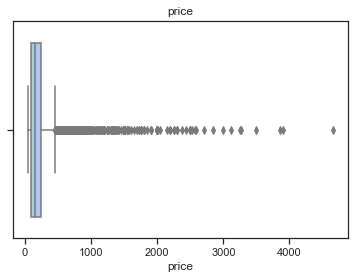

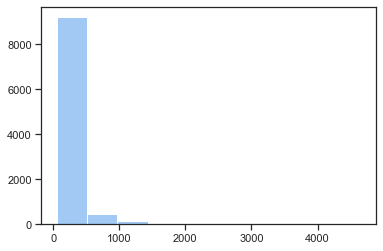

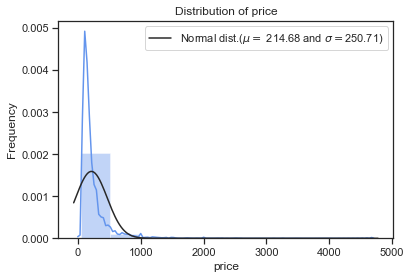

In [17]:
plot_outlier(df["price"])

In [18]:
len(df)

9838

In [19]:
len(zscore_drop_outlier(df, ["price"], THRESHOLD=3.5))

9694

Remove 144 rows

#### Remove price outlier

In [20]:
df = zscore_drop_outlier(df, ["price"], THRESHOLD=3.5)

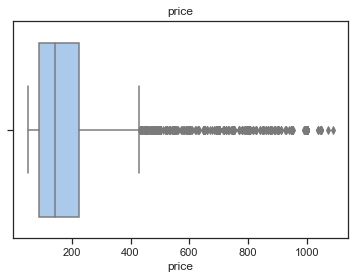

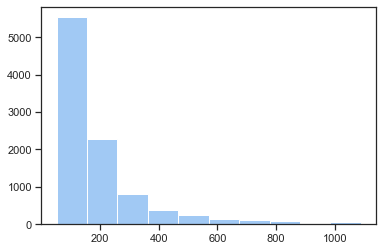

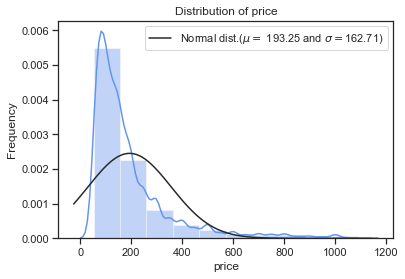

In [21]:
plot_outlier(df["price"])

## Exploratory data analysis (EDA)

In [22]:
pd.crosstab(index=df["bed_type"], columns="count")

col_0,count
bed_type,
Airbed,4
Couch,1
Futon,12
Pull-out Sofa,29
Real Bed,9648


### Features Classification

In [23]:
df.columns

Index(['name', 'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'transit', 'access', 'interaction',
       'house_rules', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_identity_verified', 'street', 'neighbourhood',
       'neighbourhood_cleansed', 'city', 'smart_location', 'latitude',
       'longitude', 'is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       'amenities', 'security_deposit_perc', 'cleaning_fee_perc',
       'guests_included', 'extra_people_perc', 'minimum_nights',
       'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_

In [24]:
location_cols = ["host_location", "host_neighbourhood", "street", "neighbourhood", "neighbourhood_cleansed",
                 "city", "smart_location", "latitude", "longitude"]

review_scores_cols = ["review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness",
                      "review_scores_checkin", "review_scores_communication", "review_scores_location",
                      "review_scores_value"]

txt_cols = ['name', 'summary', 'space', 'description', 'neighborhood_overview', 'transit', 'access',
            'interaction', 'house_rules', "host_about", ]


set_cols = ["host_verifications", "amenities"]

category_cols = ["experiences_offered", "host_response_time", "host_total_listings_count", "is_location_exact",
                 'property_type', 'room_type', "cancellation_policy", ]

boolean_cols = ["host_is_superhost", "host_identity_verified", 'requires_license', 'instant_bookable',
                'is_business_travel_ready', 'require_guest_profile_picture', 'require_guest_phone_verification']

percent_cols = ["security_deposit_perc",
                "cleaning_fee_perc", "extra_people_perc"]


numerical_cols = ["host_response_rate", "host_listings_count", "accommodates", 'bathrooms', 'bedrooms', 'beds',
                  "bed_type", "guests_included", 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
                  'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights',
                  'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60',
                  'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
                  'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
                  'calculated_host_listings_count_private_rooms',
                  'calculated_host_listings_count_shared_rooms', 'reviews_per_month']
response = "price"

time_cols = ["host_since", ]

### Special columns

#### txt columns

In [25]:
def process_text(txt_series, response_series):
    
    vectorizer = CountVectorizer(min_df=2, max_df=0.8, stop_words='english')
    stemmed = [PorterStemmer().stem(word) for word in txt_series]
    X = vectorizer.fit_transform(stemmed)
    
    tokens = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
    
    response_name = "airbnb_" + response_series.name
    tokens = pd.concat([tokens, response_series.rename(response_name)], axis=1)
    
    print("The 10 most correlated tokens in " + txt_series.name)
    print(abs(tokens.corr()[response_name]).sort_values(ascending=False)[1:11])
    
    indice_10_token = np.argsort(
        abs(tokens.corr()[response_name].values))[::-1][1:11]
    col_list = [tokens.columns[index] for index in indice_10_token]
    edited_name = [txt_series.name + "_token_" + tokens.columns[index]
                   for index in indice_10_token]
    
    df_temp = tokens[col_list]
    df_temp.columns = edited_name
    
    return df_temp

def txt_eda(df, txt_cols, response):
    for col in txt_cols:
        eda_df = process_text(df[col], df[response])
        print(eda_df.head())
        plt.figure()
        sns.heatmap(eda_df.corr(),vmax=1,square=True,annot=True,fmt=".2f",cmap="Reds")
        plt.title('Correlations among Top10 tokns in '+ col)
        plt.show()
    

所有 txt_col 的 eda
用的时间很长，先注释

In [26]:
# txt_eda(df, txt_cols, response)

column ”Name“ eda

In [27]:
eda_df = process_text(df["name"], df["price"])

The 10 most correlated tokens in name
room       0.239881
family     0.208726
private    0.154784
home       0.149236
pros       0.137264
beach      0.127967
house      0.121048
hous       0.105933
pool       0.102971
avalon     0.099756
Name: airbnb_price, dtype: float64


In [28]:
eda_df.head()

,name_token_room,name_token_family,name_token_private,name_token_home,name_token_pros,name_token_beach,name_token_house,name_token_hous,name_token_pool,name_token_avalon
0,1,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


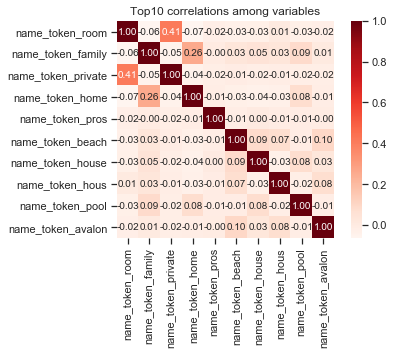

In [29]:
plt.figure()
sns.heatmap(eda_df.corr(),vmax=1,square=True,annot=True,fmt=".2f",cmap="Reds")
plt.title('Top10 correlations among variables')
plt.show()


The detail of the process_text function 

In [30]:
vectorizer = CountVectorizer(min_df=2, max_df=0.8, stop_words='english')

In [31]:
stemmed = [PorterStemmer().stem(word) for word in df['name']]
X = vectorizer.fit_transform(stemmed)

In [32]:
vectorizer.get_feature_names()

['01',
 '07',
 '10',
 '100',
 '100m',
 '109',
 '10km',
 '10min',
 '10mins',
 '11',
 '110',
 '12',
 '13',
 '14',
 '14th',
 '15',
 '150m',
 '15min',
 '15mins',
 '16',
 '17',
 '180',
 '1b',
 '1bd',
 '1bdr',
 '1bdrm',
 '1bed',
 '1bedroom',
 '1bhk',
 '1br',
 '1car',
 '1km',
 '1min',
 '1st',
 '20',
 '200',
 '200m',
 '2017',
 '2018',
 '2019',
 '20min',
 '22',
 '23',
 '25',
 '250m',
 '270',
 '28',
 '2b',
 '2ba',
 '2bath',
 '2bd',
 '2bdr',
 '2bed',
 '2bed1bath',
 '2bed2bath',
 '2bedroom',
 '2bedrooms',
 '2beds1bath',
 '2beds2bath',
 '2br',
 '2brm',
 '2bth',
 '2km',
 '2min',
 '2mins',
 '30',
 '300m',
 '3b',
 '3bd',
 '3bdr',
 '3bed',
 '3bedroom',
 '3br',
 '3km',
 '3min',
 '40',
 '41',
 '45',
 '4br',
 '4km',
 '4min',
 '50',
 '500',
 '500m',
 '50m',
 '57',
 '5br',
 '5km',
 '5min',
 '5mins',
 '600m',
 '64',
 '66',
 '6km',
 '70',
 '7th',
 '90',
 '99',
 'abod',
 'abode',
 'absolute',
 'absolutely',
 'ac',
 'access',
 'accessible',
 'accommod',
 'accommodation',
 'accomod',
 'accomodation',
 'acreag',


In [33]:
X.toarray().shape

(9694, 1583)

In [34]:
tokens = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())
tokens = pd.concat([tokens, df["price"].rename("airbnb_price")],axis = 1)

In [35]:
tokens.head()

,01,07,10,100,100m,109,10km,10min,10mins,11,...,完美的悉尼之旅,市中心,新房促销,步行达令港,舒适,近市区,近情人港,近火车站,靠近唐人街,airbnb_price
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,58.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,125.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,99.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,99.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,125.0


In [36]:
abs(tokens.corr()["airbnb_price"]).sort_values(ascending=False)[:10]

airbnb_price    1.000000
room            0.239881
family          0.208726
private         0.154784
home            0.149236
pros            0.137264
beach           0.127967
house           0.121048
hous            0.105933
pool            0.102971
Name: airbnb_price, dtype: float64

In [37]:
indice = np.argsort(abs(tokens.corr()["airbnb_price"].values))[::-1][1:11]
col_list = [tokens.columns[index] for index in indice]
edited_name = ["name_token_" + tokens.columns[index] for index in indice]
df_temp = tokens[col_list]
df_temp.columns = edited_name

In [38]:
col_list = [tokens.columns[index] for index in indice]
edited_name = ["name_token_" + tokens.columns[index] for index in indice]

In [39]:
df_temp.head()

,name_token_room,name_token_family,name_token_private,name_token_home,name_token_pros,name_token_beach,name_token_house,name_token_hous,name_token_pool,name_token_avalon
0,1,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


#### location cols

In [40]:
def haversine(lon1, lat1, lon2, lat2): # 经度1，纬度1，经度2，纬度2 （十进制度数）
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # 将十进制度数转化为弧度
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
 
    # haversine公式
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # 地球平均半径，单位为公里
    return c * r

In [41]:
heatdata = [[df["latitude"][idx], df["longitude"][idx], df["price"][idx]]
            for idx in range(len(df))]

##### Draw a map of all house
The Latitude and longitude of Sydney Townhall is **-33.873098, 151.206093**

In [42]:
markers = {
    "Sydney_Townhall": [-33.873098, 151.206093],
    "Bondi_Beach":[-33.891505, 151.277058],
    "Opera_House":[-33.856717, 151.215308],
}

In [43]:
san_map = folium.Map(location=markers["Sydney_Townhall"], zoom_start=12)

for i,pos in enumerate(zip(df["latitude"], df["longitude"])):
    folium.CircleMarker(
        location=[pos[0], pos[1]],
        radius=1,
        fill=True,
        fill_color='red',
        fill_opacity=0.4
    ).add_to(san_map)
    
san_map.save('basemap.html')


##### Draw a heatmap of  house price

In [44]:
heat_map = folium.Map(location=markers["Sydney_Townhall"], zoom_start=12)
HeatMap(heatdata,
        radius=11,
        blur=25
       ).add_to(heat_map)
heat_map.save("heatmap.html")
heat_map

In [45]:
temp_df = pd.DataFrame()
for marker in list(markers.keys()):

    temp = [haversine(df["longitude"][idx], df["latitude"][idx], markers[marker][1], 
           markers[marker][0]) for idx in range(len(df))]
    temp_df[marker] = temp
    
temp_df = pd.concat([temp_df, df["price"]], axis=1)
temp_df.head()

,Sydney_Townhall,Bondi_Beach,Opera_House,price
0,18.959880,25.158097,18.305198,58.0
1,15.450186,15.218945,13.457675,125.0
2,3.381259,9.214408,5.252960,99.0
3,6.858509,12.960545,8.421628,99.0
4,3.811067,5.104834,5.320834,125.0


In [46]:
abs(temp_df.corr()["price"]).sort_values(ascending=False)


price              1.000000
Sydney_Townhall    0.094238
Opera_House        0.057520
Bondi_Beach        0.013753
Name: price, dtype: float64

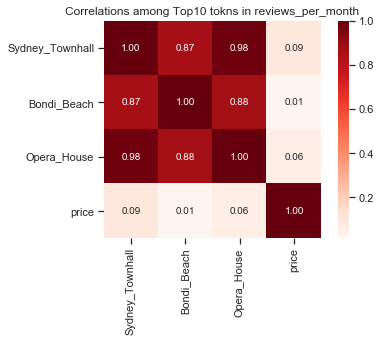

In [47]:
sns.heatmap(temp_df.corr(),vmax=1,square=True,annot=True,fmt=".2f",cmap="Reds")
plt.title('Correlations among Top10 tokns in '+ col)
plt.show()

In [48]:
df[location_cols]

,host_location,host_neighbourhood,street,neighbourhood,neighbourhood_cleansed,city,smart_location,latitude,longitude
0,"Cheltenham, New South Wales, Australia",None,"Beecroft, NSW, Australia",None,Hornsby,Beecroft,"Beecroft, Australia",-33.74843,151.06609
1,"New South Wales, Australia",None,"Dee Why, NSW, Australia",None,Warringah,Dee Why,"Dee Why, Australia",-33.75546,151.29509
2,AU,Camperdown,"Camperdown, NSW, Australia",Camperdown,Marrickville,Camperdown,"Camperdown, Australia",-33.89182,151.17723
3,"Sydney, New South Wales, Australia",Summer Hill,"Summer Hill, NSW, Australia",Summer Hill,Ashfield,Summer Hill,"Summer Hill, Australia",-33.89516,151.13671
4,AU,Kensington,"Kensington, NSW, Australia",Kensington,Randwick,Kensington,"Kensington, Australia",-33.90404,151.22385
5,"New South Wales, Australia",Haymarket,"Sydney, NSW, Australia",Central Business District,Sydney,Sydney,"Sydney, Australia",-33.86783,151.20329
6,Australia,Darlinghurst,"Darlinghurst, NSW, Australia",Darlinghurst,Sydney,Darlinghurst,"Darlinghurst, Australia",-33.87787,151.22101
7,"Hong Kong, Hong Kong",Chippendale,"Chippendale, NSW, Australia",Darlington,Sydney,Chippendale,"Chippendale, Australia",-33.88814,151.19540
8,"Sydney, New South Wales, Australia",None,"Bondi Beach, NSW, Australia",Tamarama,Waverley,Bondi Beach,"Bondi Beach, Australia",-33.89922,151.27382
9,"Northern Beaches of Sydney, New South Wales",None,"Dee Why, NSW, Australia",None,Warringah,Dee Why,"Dee Why, Australia",-33.75598,151.29030


##### Draw Crime rate map

Select "neighbourhood_cleansed" column

In [49]:
df["neighbourhood_cleansed"].unique()

array(['Hornsby', 'Warringah', 'Marrickville', 'Ashfield', 'Randwick',
       'Sydney', 'Waverley', 'Botany Bay', 'Manly', 'North Sydney',
       'Ryde', 'Leichhardt', 'Sutherland Shire', 'Mosman',
       'City Of Kogarah', 'Pittwater', 'Woollahra', 'Lane Cove',
       'Parramatta', 'Rockdale', 'Hunters Hill', 'Willoughby', 'Penrith',
       'Canada Bay', 'Fairfield', 'Burwood', 'Auburn', 'The Hills Shire',
       'Canterbury', 'Ku-Ring-Gai', 'Campbelltown', 'Strathfield',
       'Bankstown', 'Blacktown', 'Camden', 'Hurstville', 'Holroyd',
       'Liverpool'], dtype=object)

Rate per 100,000 population: 

source: http://crimetool.bocsar.nsw.gov.au/bocsar/

In [50]:
crime_rate = {
    'Hornsby': 390.8,
    'Warringah':239.3,
    'Marrickville':406.4,
    'Ashfield': 294.9,
    'Randwick':470.5,
    'Sydney':4970.8,
    'Waverley':375.5,
    'Botany Bay':307.8,
    'Manly':978.9,
    'North Sydney':487.7,
    'Ryde': 238.2,
    'Leichhardt':263.0,
    'Sutherland Shire':247.4,
    'Mosman':117.8,
    'City Of Kogarah':417.0,
    'Pittwater':91.3,
    'Woollahra':177.8,
    'Lane Cove':195.1,
    'Parramatta':1079.3,
    'Rockdale':331.9,
    'Hunters Hill':307.8,
    'Willoughby':130.0,
    'Penrith':2129.0,
    'Canada Bay': 146.6,
    'Fairfield':657.4,
    'Burwood':377.6,
    'Auburn':439.0,
    'The Hills Shire':146.6,
    'Canterbury':162.8,
    'Ku-Ring-Gai':87.6,
    'Campbelltown':1247.1,
    'Strathfield':244.1,
    'Bankstown':577.8,
    'Blacktown':782.0,
    'Camden':478.0,
    'Hurstville':342.1,
    'Holroyd':0.1,
    'Liverpool':1008.2,
}

neighbour_location = {
    'Hornsby': [-33.703226, 151.098387],
    'Warringah':239.3,
    'Marrickville':406.4,
    'Ashfield': 294.9,
    'Randwick':470.5,
    'Sydney':4970.8,
    'Waverley':375.5,
    'Botany Bay':307.8,
    'Manly':978.9,
    'North Sydney':487.7,
    'Ryde': 238.2,
    'Leichhardt':263.0,
    'Sutherland Shire':247.4,
    'Mosman':117.8,
    'City Of Kogarah':417.0,
    'Pittwater':91.3,
    'Woollahra':177.8,
    'Lane Cove':195.1,
    'Parramatta':1079.3,
    'Rockdale':331.9,
    'Hunters Hill':307.8,
    'Willoughby':130.0,
    'Penrith':2129.0,
    'Canada Bay': 146.6,
    'Fairfield':657.4,
    'Burwood':377.6,
    'Auburn':439.0,
    'The Hills Shire':146.6,
    'Canterbury':162.8,
    'Ku-Ring-Gai':87.6,
    'Campbelltown':1247.1,
    'Strathfield':244.1,
    'Bankstown':577.8,
    'Blacktown':782.0,
    'Camden':478.0,
    'Hurstville':342.1,
    'Holroyd':0.1,
    'Liverpool':1008.2,
}


In [51]:
# san_map = folium.Map(location = markers["Sydney_Townhall"], zoom_start = 12)

# # instantiate a mark cluster object for the incidents in the dataframe
# incidents = plugins.MarkerCluster().add_to(san_map)

# # loop through the dataframe and add each data point to the mark cluster
# for lat, lng, label, in zip(data.Y, data.X, cdata.Category):
#     folium.Marker(
#         location=[lat, lng],
#         icon=None,
#         popup=label,
#     ).add_to(incidents)

# # add incidents to map
# san_map.add_child(incidents)



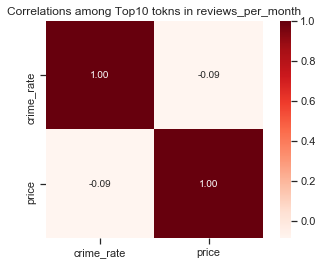

In [52]:
crime = pd.DataFrame([crime_rate[x] for x in df["neighbourhood_cleansed"]],columns=["crime_rate"])
temp_df = pd.concat([crime, df["price"]],axis=1)

sns.heatmap(temp_df.corr(),vmax=1,square=True,annot=True,fmt=".2f",cmap="Reds")
plt.title('Correlations among Top10 tokns in '+ col)
plt.show()

#### review_scores_cols

In [53]:
review_scores_cols

['review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value']

In [54]:
temp = df["review_scores_accuracy"] + df["review_scores_cleanliness"] + df["review_scores_checkin"] + \
    df["review_scores_communication"] + \
    df["review_scores_location"] + df["review_scores_value"]

### Category columns

#### set_cols

#### category_cols

#### boolean_cols

### Numerical columns

#### percent_cols

#### numerical columns

#### time_cols

### Response: "Price"

## Feature Engineering


## Modelling

## Summit